Copyright **`(c)`** 2024 Giovanni Squillero `<giovanni.squillero@polito.it>`  
[`https://github.com/squillero/computational-intelligence`](https://github.com/squillero/computational-intelligence)  
Free for personal or classroom use; see [`LICENSE.md`](https://github.com/squillero/computational-intelligence/blob/master/LICENSE.md) for details.  

# Set Cover problem

See: https://en.wikipedia.org/wiki/Set_cover_problem

In [188]:
from random import random, seed
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from itertools import accumulate

from icecream import ic

## Reproducible Initialization

If you want to get reproducible results, use `rng` (and restart the kernel); for non-reproducible ones, use `np.random`.

In [189]:
UNIVERSE_SIZE = 1000
NUM_SETS = 200
DENSITY = 0.1

# Reproducable random sequence
rng = np.random.Generator(np.random.PCG64([UNIVERSE_SIZE, NUM_SETS, int(10_000 * DENSITY)]))

In [190]:
# DON'T EDIT THESE LINES!
# SETS : Boolean array of shape (NUMBER_OF_SETS, UNIVERSE_SIZE)
SETS = np.random.random((NUM_SETS, UNIVERSE_SIZE)) < DENSITY
# Each set is represented by a vector of boolean values :
#   -   1 : the element is present in the set
#   -   0 : the element is not present in the set
for s in range(UNIVERSE_SIZE):
    if not np.any(SETS[:, s]):
        SETS[np.random.randint(NUM_SETS), s] = True
COSTS = np.pow(SETS.sum(axis=1), 1.1)

## Helper Functions

In [191]:
def valid(solution):
    """Checks wether solution is valid (ie. covers all universe)"""
    phenotype = np.logical_or.reduce(SETS[solution])
    return np.all(phenotype)


def cost(solution):
    """Returns the cost of a solution (to be minimized)"""
    return COSTS[solution].sum()

## Have Fun!

In [192]:
# A dumb solution of "all" sets
solution = np.full(NUM_SETS, True)
ic(valid(solution), cost(solution))
None

ic| valid(solution): np.True_
    cost(solution): np.float64(31817.95634359183)


In [193]:
# A random solution with random 50% of the sets
solution = rng.random(NUM_SETS) < .5
ic(valid(solution), cost(solution))
None


ic| valid(solution): np.True_
    cost(solution): np.float64(17248.264205081472)


In [194]:
def fitness(solution : np.ndarray):
    # Minimise the cost 
    return (valid(solution), -cost(solution))

## A  Very Simple RMHC

In [195]:
def single_mutation(solution : np.ndarray) -> np.ndarray :
    new_solution = solution.copy()    
    i = rng.integers(0, NUM_SETS)
    # Select one bit randomly then flip it 
    new_solution[i] = not new_solution[i]
    return new_solution

ic| fitness(solution): (np.True_, np.float64(-31817.95634359183))
ic| fitness(solution): (np.True_, np.float64(-5958.572134473125))
ic| history.index(fitness(solution)[1]): 495


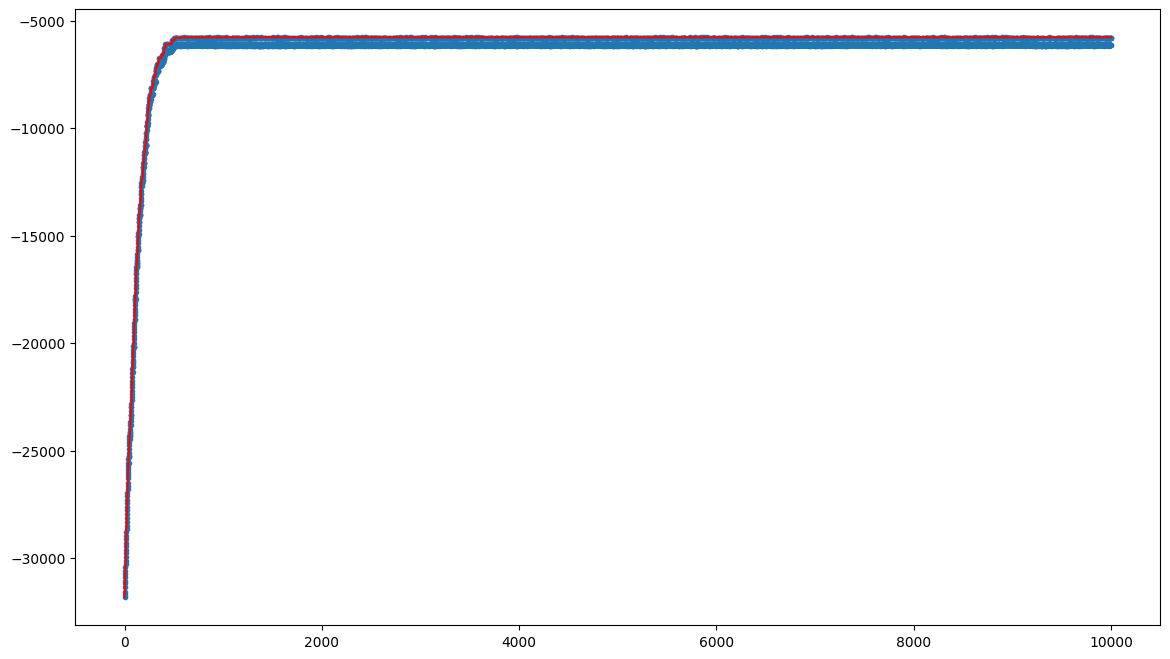

In [196]:
solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]]
ic(fitness(solution))

tweak = single_mutation

for steps in range(10000) :
    new_solution = tweak(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if fitness(new_solution) > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)
        #ic(steps, solution, fitness(solution))

ic(fitness(solution))
ic(history.index(fitness(solution)[1])) #Last Improvement

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")



## RMHC with a more powerful tweak

In [197]:
def multiple_mutation(solution : np.ndarray) -> np.ndarray :
    # Improvement : Can start from a unfeasible solution
    new_solution = solution.copy()
    mask = rng.random(NUM_SETS)  < 0.01
    # Where the mask is true, the bit is flipped
    new_solution = np.logical_xor(solution,mask)
    return new_solution

ic| fitness(solution): 

(np.True_, np.float64(-13678.667661242405))
ic| fitness(solution): (np.True_, np.float64(-5517.142506652236))
ic| history.index(fitness(solution)[1]): 8427


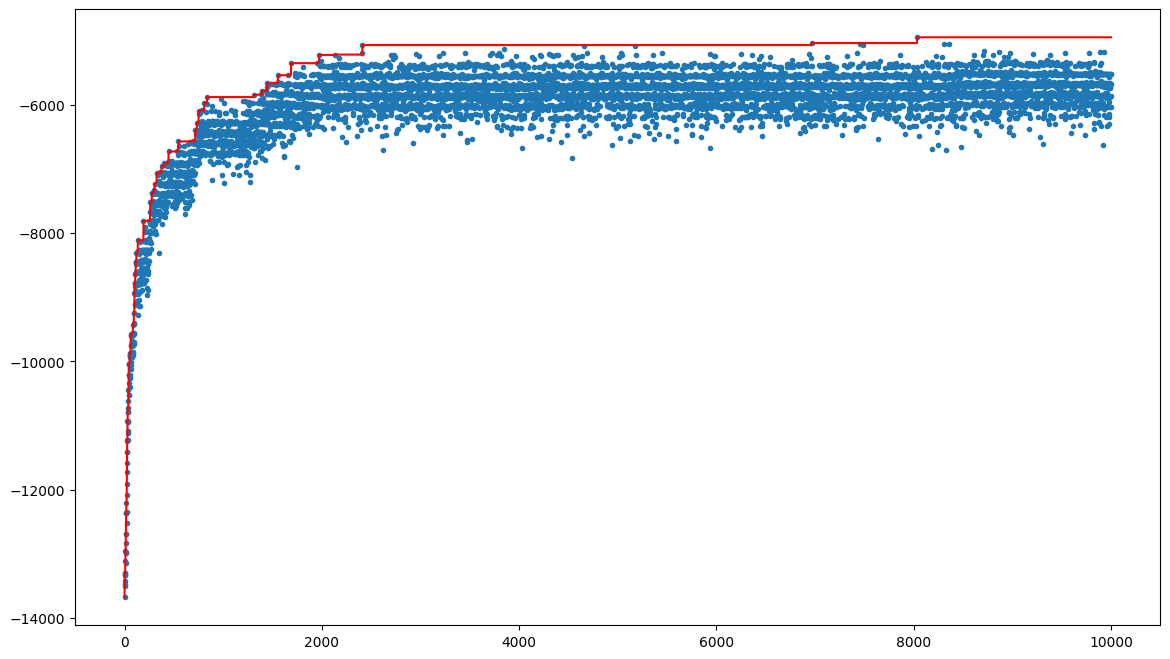

In [198]:
solution = rng.random(NUM_SETS) < 0.4
solution_fitness = fitness(solution)
history = [solution_fitness[1]]
ic(fitness(solution))

tweak = multiple_mutation

for steps in range(10000) :
    new_solution = tweak(solution)
    f = fitness(new_solution)
    history.append(f[1])
    if fitness(new_solution) > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)
        #ic(steps, solution, fitness(solution))

ic(fitness(solution))
ic(history.index(fitness(solution)[1]))

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

## Improved RMHC

In [199]:
def multiple_mutation_strength(solution : np.ndarray, strength : float = 0.3) -> np.ndarray :
    mask = rng.random(NUM_SETS)  < strength    
    if not np.any(mask) : 
        # Solution of all False
        mask[np.random.randint(NUM_SETS)] = True
    new_solution = solution.copy()    
    # Where the mask is true, the bit is flipped
    new_solution = np.logical_xor(solution,mask)
    return new_solution

ic| fitness(solution): (np.True_, np.float64(-31817.95634359183))
ic| fitness(solution): (np.True_, np.float64(-5961.250620180162))
ic| history.index(fitness(solution)[1]): 814


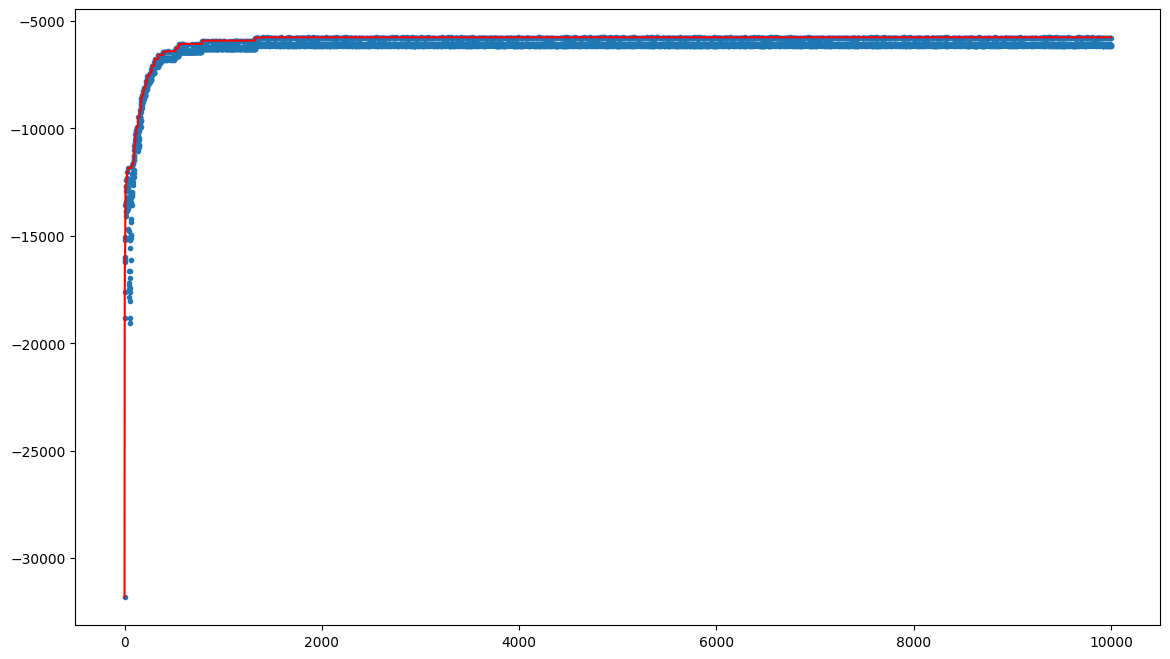

In [200]:
BUFFER_SIZE = 50

solution = rng.random(NUM_SETS) < 1
solution_fitness = fitness(solution)
history = [solution_fitness[1]]
ic(fitness(solution))

strength = 0.5
buffer = list()

for steps in range(10000) :
    # ------- ADAPTIVE -------
    # if steps % 1000:
    #     strength /= 2
    # ------- SELF-ADAPTIVE -------
    new_solution = multiple_mutation_strength(solution, strength)
    f = fitness(new_solution)
    history.append(float(f[1]))
    buffer.append(f > solution_fitness)
    buffer = buffer[-BUFFER_SIZE:] # taking last elements
    if sum(buffer) > 10:
        strength *= 1.1
    elif sum(buffer) < 10:
        strength /= 1.1

    if fitness(new_solution) > solution_fitness:
        solution = new_solution
        solution_fitness = fitness(solution)
        #ic(steps, solution, fitness(solution))

ic(fitness(solution))
ic(history.index(fitness(solution)[1]))


# Plotting
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")

## Now let's have fun ! (or atleast try to...)

**1st Idea :** 

Some sets contain elements that are not present in any other set. Let's call them essential sets. They are necessarly part of the solution. Therefore, we can initialize a solution containing these sets and prevent the search algorithm from going to states in which they are not included. 

While we're at it, we can also look for elements included in none of the sets in our search of essential sets. If true, the problem is not feasible. 

In [201]:
def find_essential_sets() -> np.ndarray:
    """Find sets that contain elements not present in any other set.
    Raises an error if any element is not covered by any set, indicating that the problem is infeasible.
    """
    essential_sets = np.full(NUM_SETS, False)  # Initially, no set is essential
    
    for element in range(UNIVERSE_SIZE):
        sets_covering_element = np.where(SETS[:, element])[0]  # Find which sets cover this element
        
        if len(sets_covering_element) == 0:
            # If no set covers the element, the problem is infeasible
            raise ValueError(f"Problem is infeasible: element {element} is not covered by any set.")
        
        if len(sets_covering_element) == 1:
            # If only one set covers the element, it is essential
            essential_sets[sets_covering_element[0]] = True
    
    return essential_sets

def multiple_mutation_locked_essential(solution: np.ndarray, essential_sets: np.ndarray) -> np.ndarray:
    """Perform multiple mutations but keep essential sets locked."""
    new_solution = solution.copy()
    
    # Generate a mutation mask with a 1% chance for each set
    mask = rng.random(NUM_SETS) < 0.01
    
    # Prevent mutation of essential sets by setting their mask to False
    mask[essential_sets] = False
    
    # Apply mutations where the mask is True (non-essential sets)
    new_solution = np.logical_xor(solution, mask)
    
    return new_solution

ic| fitness(solution): (np.True_, np.float64(-31817.95634359183))
ic| fitness(solution): (np.True_, np.float64(-5395.7693753950725))
ic| history.index(fitness(solution)[1]): 3622


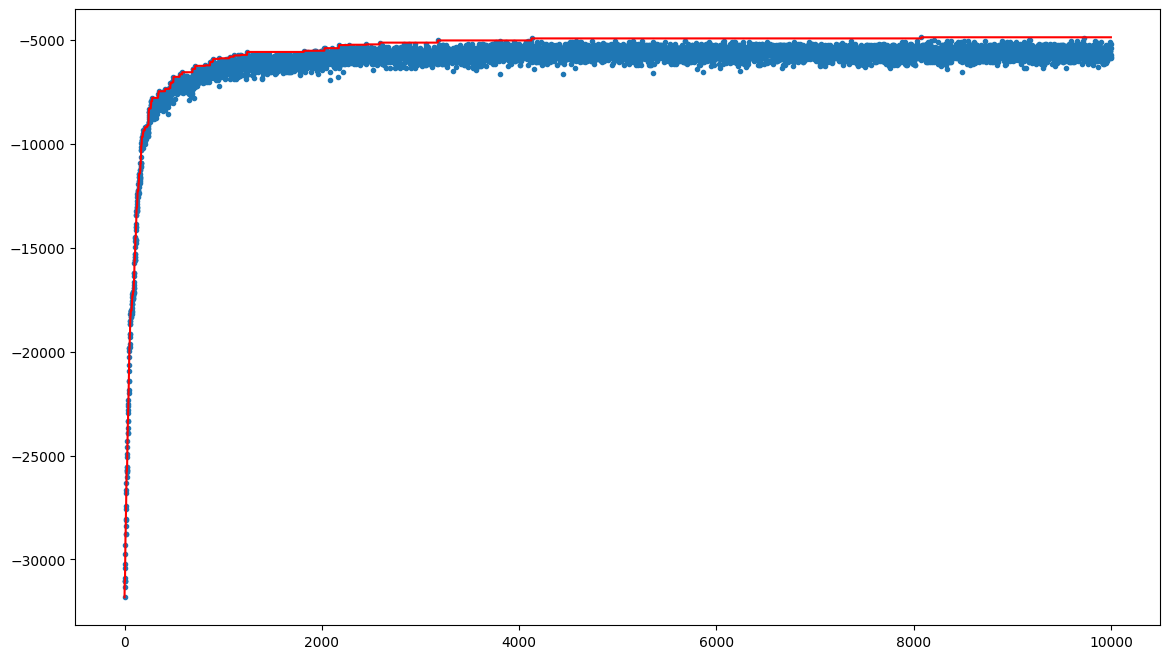

In [202]:
essential_sets = find_essential_sets()
solution = rng.random(NUM_SETS) < 1

ic(fitness(solution))

solution_fitness = fitness(solution)
history = [solution_fitness[1]]

# Use the mutation with locked essential sets
for steps in range(10000):
    new_solution = multiple_mutation_locked_essential(solution, essential_sets)
    f = fitness(new_solution)
    history.append(f[1])
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = f

ic(fitness(solution))
ic(history.index(fitness(solution)[1]))

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")


In [203]:
def multiple_mutation_strength_locked_essential(solution : np.ndarray, essential_sets: np.ndarray,  strength : float = 0.3) -> np.ndarray :
    new_solution = solution.copy()    

    mask = rng.random(NUM_SETS)  < strength    
    if not np.any(mask) : 
        # Solution of all False
        mask[np.random.randint(NUM_SETS)] = True

    # Prevent mutation of essential sets by setting their mask to False
    mask[essential_sets] = False

    # Apply mutations where the mask is True (non-essential sets)
    new_solution = np.logical_xor(solution,mask)
    return new_solution

ic| fitness(solution): (np.True_, np.float64(-31817.95634359183))
ic| fitness(solution): (np.True_, np.float64(-5508.850407215814))
ic| history.index(fitness(solution)[1]): 7345


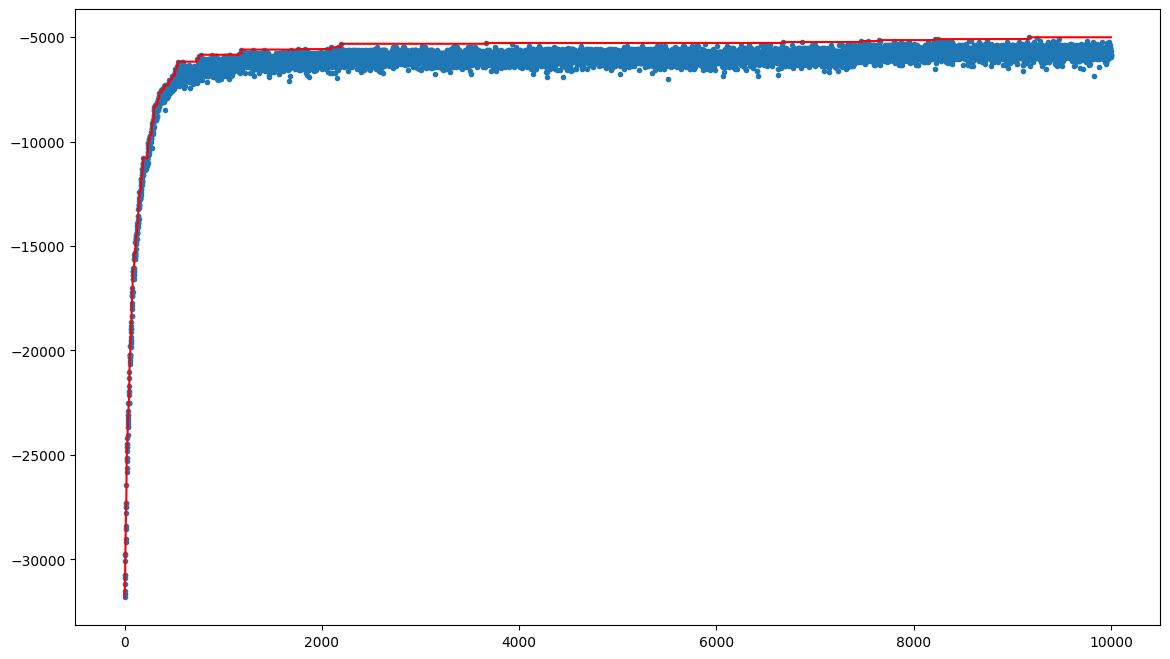

In [204]:
essential_sets = find_essential_sets()
solution = rng.random(NUM_SETS) < 1

ic(fitness(solution))

solution_fitness = fitness(solution)
history = [solution_fitness[1]]

strength = 0.5
buffer = list()

# Use the mutation with locked essential sets and with the strenght
for steps in range(10000):
    new_solution = multiple_mutation_locked_essential(solution, essential_sets)
    f = fitness(new_solution)
    history.append(f[1])
    buffer.append(f > solution_fitness)
    buffer = buffer[-BUFFER_SIZE:] # taking last elements
    if sum(buffer) > 10:
        strength *= 1.1
    elif sum(buffer) < 10:
        strength /= 1.1        
    if f > solution_fitness:
        solution = new_solution
        solution_fitness = f

ic(fitness(solution))
ic(history.index(fitness(solution)[1]))

# Plotting
plt.figure(figsize=(14, 8))
plt.plot(
    range(len(history)),
    list(accumulate(history, max)),
    color="red",
)
_ = plt.scatter(range(len(history)), history, marker=".")